<a href="https://colab.research.google.com/github/Rosie-Brigham/colab-gists/blob/main/model_3c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at `cs231n notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/all_submissions_01_02_21'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7fbff1e0c350>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7fbff1e0ca90>}


In [ ]:
print(class_names)

['achnabrech', 'baluachraig', 'blanes', 'bothwell', 'caerlaverock', 'carn', 'clava', 'doon', 'drumtroddanc', 'drumtroddans', 'kinniel', 'lochranza', 'machrie', 'maiden', 'ness', 'rothesay', 'semple', 'tantallon', 'tarves', 'tealing']


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



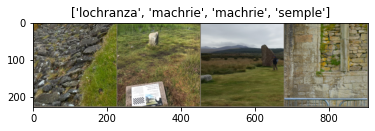

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print(f'Best epoch: {best_epoch}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to length of the class name list.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                      #  num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2329 Acc: 0.6587
val Loss: 0.5941 Acc: 0.8383

Epoch 1/24
----------
train Loss: 0.8024 Acc: 0.7675
val Loss: 0.5792 Acc: 0.8443

Epoch 2/24
----------
train Loss: 0.7317 Acc: 0.7935
val Loss: 0.5304 Acc: 0.8605

Epoch 3/24
----------
train Loss: 0.6330 Acc: 0.8129
val Loss: 0.5402 Acc: 0.8599

Epoch 4/24
----------
train Loss: 0.5813 Acc: 0.8351
val Loss: 0.5492 Acc: 0.8743

Epoch 5/24
----------
train Loss: 0.5310 Acc: 0.8458
val Loss: 0.5136 Acc: 0.8808

Epoch 6/24
----------
train Loss: 0.4712 Acc: 0.8594
val Loss: 0.5616 Acc: 0.8551

Epoch 7/24
----------
train Loss: 0.3793 Acc: 0.8929
val Loss: 0.4042 Acc: 0.8982

Epoch 8/24
----------
train Loss: 0.3134 Acc: 0.9122
val Loss: 0.4888 Acc: 0.8850

Epoch 9/24
----------
train Loss: 0.3011 Acc: 0.9183
val Loss: 0.3870 Acc: 0.9012

Epoch 10/24
----------
train Loss: 0.2831 Acc: 0.9191
val Loss: 0.3967 Acc: 0.8994

Epoch 11/24
----------
train Loss: 0.2897 Acc: 0.9238
val Loss: 0.3629 Acc: 0.9114

Ep

In [ ]:
# path_one = "/content/drive/MyDrive/models/model_6_25e_ft.pt" 

In [ ]:

# torch.save(model_ft.state_dict(), path_one)

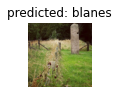

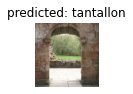

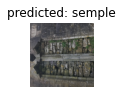

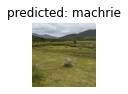

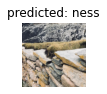

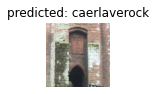

In [ ]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 20)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
# Carry on training convnet
path_two = "/content/drive/MyDrive/models/model_6_30e_conv.pt"
model_conv.load_state_dict(torch.load(path_two))
# model_conv.eval()


<All keys matched successfully>

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8013 Acc: 0.7592
val Loss: 0.5413 Acc: 0.8587

Epoch 1/29
----------
train Loss: 0.7513 Acc: 0.7751
val Loss: 0.5251 Acc: 0.8527

Epoch 2/29
----------
train Loss: 0.7510 Acc: 0.7736
val Loss: 0.5001 Acc: 0.8617

Epoch 3/29
----------
train Loss: 0.7564 Acc: 0.7719
val Loss: 0.5230 Acc: 0.8515

Epoch 4/29
----------
train Loss: 0.7261 Acc: 0.7875
val Loss: 0.5444 Acc: 0.8479

Epoch 5/29
----------
train Loss: 0.7330 Acc: 0.7878
val Loss: 0.5888 Acc: 0.8425

Epoch 6/29
----------
train Loss: 0.7458 Acc: 0.7776
val Loss: 0.5075 Acc: 0.8605

Epoch 7/29
----------
train Loss: 0.6389 Acc: 0.8097
val Loss: 0.4790 Acc: 0.8629

Epoch 8/29
----------
train Loss: 0.6742 Acc: 0.7982
val Loss: 0.4965 Acc: 0.8527

Epoch 9/29
----------
train Loss: 0.6344 Acc: 0.8149
val Loss: 0.4892 Acc: 0.8635

Epoch 10/29
----------
train Loss: 0.6834 Acc: 0.7984
val Loss: 0.4804 Acc: 0.8635

Epoch 11/29
----------
train Loss: 0.6361 Acc: 0.8155
val Loss: 0.4591 Acc: 0.8713

Ep

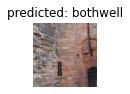

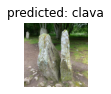

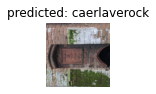

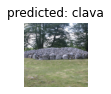

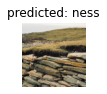

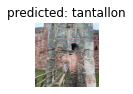

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Further Learning
-----------------

If you would like to learn more about the applications of transfer learning,
checkout our `Quantized Transfer Learning for Computer Vision Tutorial <https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html>`_.





In [ ]:

path_two = "/content/drive/MyDrive/models/model_6_60e_conv.pt" 

In [ ]:
torch.save(model_conv.state_dict(), path_two)

In [ ]:
# model_conv.load_state_dict(torch.load(path_two))
# model_conv.eval()

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.cuda()
            y = y.cuda()
            model.cuda()
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

print("Checking accuracy on Training Set - covnet")
check_accuracy(dataloaders['train'], model_conv)

print("Checking accuracy on Test Set")
check_accuracy(dataloaders['val'], model_conv)


print("Checking accuracy on Training Set finetuned")
check_accuracy(dataloaders['train'], model_ft)

print("Checking accuracy on Test Set")
check_accuracy(dataloaders['val'], model_ft)

Checking accuracy on Training Set - covnet
Got 3091 / 3463 with accuracy 89.26
Checking accuracy on Test Set
Got 1453 / 1670 with accuracy 87.01
Checking accuracy on Training Set finetuned
Got 3332 / 3463 with accuracy 96.22
Checking accuracy on Test Set
Got 1535 / 1670 with accuracy 91.92


In [ ]:
# model_conv.load_state_dict(torch.load(path_two))
# model_conv.eval()

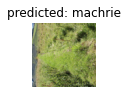

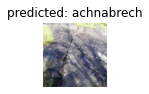

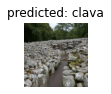

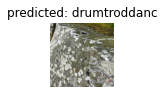

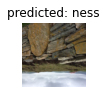

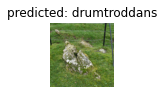

In [ ]:
visualize_model(model_conv)